In [11]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from scipy.stats import binom_test
from matplotlib.markers import TICKDOWN
import datetime
from scipy.stats import norm

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
####################################################################################
#    Aggregates SNR (.dat), latency (.dat), and ROI photos (png)
#            scraped from PhotoZ
#    Given ROI files in format slice#_rois.dat 
# 8/23/23 We want to add:
#     Take into account the RELATIVE STIM LOCATION within every barrel. Does velocity depend on distance from stimulating location?
#            New column: distance (um) from stim loc to relevant barrel pair boundary (1:2)
#            New column: distance (um) from stim loc to relevant barrel pair boundary (2:3)
#
#     METHOD
#         To calculate stim location to boundary, take these files produced by MovieMaker2.ipynb:
#             electrode.dat
#             corners_layer.dat
#             corners_barrel.dat
#         Calculate: Distance to lower barrel, distance to higher barrel,
#                    Distance to lower layer, distance to higher layer
#                       (if applicable for each)
####################################################################################

In [2]:
# Load data, not from Drive for Desktop since PhotoZ complains about loading zda from Drive
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/"
data_dir = 'C:/Users/jjudg/Downloads/'
cell_type_prefix = 'scnn1a'
csv_prefix = cell_type_prefix + '_all_slices-final.csv'

# load the all-data CSV dir
df = pd.read_csv(data_dir + csv_prefix)
df = pd.DataFrame(df)
df

,Date,Slice/Loc/Rec,Slice Edge,Medial Dir,Slice Location,Stim Location,L4 barrel 1 Latency,L4 barrel 2 Latency,L4 barrel 3 Latency,L4 barrel 1 SNR,...,abs(delta 1),abs(delta 2),Distance to Barrel 1,Distance to Barrel 2,Distance to Layer n1,Distance to Layer n2,Distance to Barrel A,Distance to Barrel B,Distance to Layer nA,Distance to Layer nB
0,2/8/2023,02_01_02,NaN,NaN,NaN,L4,47.7369,49.4509,49.8291,1.55191,...,NaN,NaN,NaN,NaN,NaN,NaN,215.228351,174.000000,180.093736,191.535134
1,2/10/2023,04_01_07,NaN,NaN,NaN,L4,52.7236,49.9505,51.1170,6.20749,...,2.7731,NaN,NaN,NaN,NaN,NaN,151.086327,213.337695,149.891961,202.354632
2,2/14/2023,02_01_01,NaN,NaN,NaN,L4,47.5447,49.7343,49.9818,2.20928,...,NaN,NaN,NaN,NaN,NaN,NaN,198.974687,232.730513,132.022414,229.523778
3,2/14/2023,03_01_03,NaN,NaN,NaN,L4,51.1559,50.3250,51.2512,4.77084,...,NaN,0.9262,NaN,NaN,NaN,NaN,228.000000,162.000000,159.011987,199.155462
4,2/28/2023,02_01_01,NaN,NaN,NaN,L5,50.3009,50.8406,49.3457,2.94039,...,NaN,1.4949,NaN,NaN,NaN,NaN,44.346286,328.107622,171.794234,154.795349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,10/19/2023,05_06_02,down/right,down/left,Anterior,L2/3,52.5402,51.2761,54.6519,5.21410,...,1.2641,NaN,NaN,NaN,NaN,NaN,24.997803,181.431965,314.744870,103.797327
170,10/19/2023,06_01_01,down,right,Posterior,L4,50.6833,50.3330,49.7638,10.10250,...,0.3503,NaN,NaN,NaN,NaN,NaN,118.898651,202.376373,288.667605,69.296479
171,10/19/2023,06_02_02,down,right,Posterior,L4,50.3022,51.0678,52.1046,27.20220,...,0.7656,1.0368,NaN,NaN,NaN,NaN,151.005549,215.305522,75.027164,306.897033
172,10/19/2023,06_03_01,down,right,Posterior,L2/3,52.3050,51.7377,50.8937,8.65164,...,0.5673,NaN,NaN,NaN,NaN,NaN,322.923386,22.555042,70.935246,350.093066


In [3]:
# Choose one sex
sex = 'F'
df = df[df["Sex"] == sex]

In [4]:
# filter out rows marked in column Exclude 
df2 = df[df["Exclude Reason"].isnull()]
data = {}

for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    print("Barrel pairs in", stim_loc)
    # count number of barrel pairs with no signal crossing
    n_barrel_no_cross = len(df2[df2['# no crossings 2/3'] > 0])
    n_barrel_no_cross += len(df2[df2['# no crossings 1/2'] > 0])
    print("\t", n_barrel_no_cross, "no crossing out of", len(df2) * 2, "in layer", stim_loc)

    # count number of barrel pairs with signal crossing
    n_barrel_cross = len(df2[df2['# crossings 2/3'] > 0])
    n_barrel_cross += len(df2[df2['# crossings 1/2'] > 0])
    print("\t", n_barrel_cross, "crossing out of", len(df2) * 2, "in layer", stim_loc)

    # count number of barrel pairs with no signal
    n_barrel_none = len(df2) * 2 - n_barrel_cross - n_barrel_no_cross
    print("\t", n_barrel_none, "no signal out of", len(df2) * 2, "in layer", stim_loc)
    
    data[stim_loc] = {}
    data[stim_loc]['n_barrel_no_cross'] = n_barrel_no_cross
    data[stim_loc]['n_barrel_cross'] = n_barrel_cross
    data[stim_loc]['n_barrel_none'] = n_barrel_none
    data[stim_loc]['total'] = len(df2) * 2 - n_barrel_none
    
# Now rostral vs caudal
for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    for slice_loc in ['Anterior', 'Posterior']:
        print("\n", slice_loc)
        df2_sl = df2[df2['Slice Location'] == slice_loc]
        print("Barrel pairs in", stim_loc)
        # count number of barrel pairs with no signal crossing
        n_barrel_no_cross = len(df2_sl[df2_sl['# no crossings 2/3'] > 0])
        n_barrel_no_cross += len(df2_sl[df2_sl['# no crossings 1/2'] > 0])
        print("\t", n_barrel_no_cross, "no crossing out of", len(df2_sl) * 2, "in layer", stim_loc)

        # count number of barrel pairs with signal crossing
        n_barrel_cross = len(df2_sl[df2_sl['# crossings 2/3'] > 0])
        n_barrel_cross += len(df2_sl[df2_sl['# crossings 1/2'] > 0])
        print("\t", n_barrel_cross, "crossing out of", len(df2_sl) * 2, "in layer", stim_loc)

        # count number of barrel pairs with no signal
        n_barrel_none = len(df2_sl) * 2 - n_barrel_cross - n_barrel_no_cross
        print("\t", n_barrel_none, "no signal out of", len(df2_sl) * 2, "in layer", stim_loc)

        data[stim_loc][slice_loc] = {}
        data[stim_loc][slice_loc]['n_barrel_no_cross'] = n_barrel_no_cross
        data[stim_loc][slice_loc]['n_barrel_cross'] = n_barrel_cross
        data[stim_loc][slice_loc]['n_barrel_none'] = n_barrel_none
        data[stim_loc][slice_loc]['total'] = len(df2) * 2 - n_barrel_none


Barrel pairs in L2/3
	 14 no crossing out of 88 in layer L2/3
	 33 crossing out of 88 in layer L2/3
	 41 no signal out of 88 in layer L2/3
Barrel pairs in L4
	 50 no crossing out of 142 in layer L4
	 24 crossing out of 142 in layer L4
	 68 no signal out of 142 in layer L4
Barrel pairs in L5
	 7 no crossing out of 16 in layer L5
	 2 crossing out of 16 in layer L5
	 7 no signal out of 16 in layer L5

 Anterior
Barrel pairs in L2/3
	 8 no crossing out of 42 in layer L2/3
	 14 crossing out of 42 in layer L2/3
	 20 no signal out of 42 in layer L2/3

 Posterior
Barrel pairs in L2/3
	 6 no crossing out of 38 in layer L2/3
	 13 crossing out of 38 in layer L2/3
	 19 no signal out of 38 in layer L2/3

 Anterior
Barrel pairs in L4
	 20 no crossing out of 60 in layer L4
	 7 crossing out of 60 in layer L4
	 33 no signal out of 60 in layer L4

 Posterior
Barrel pairs in L4
	 20 no crossing out of 58 in layer L4
	 7 crossing out of 58 in layer L4
	 31 no signal out of 58 in layer L4

 Anterior
Barrel

{'# no crossing': [7.960973163348812, 9.555497043061454, 29.397236789606566], '# crossing': [12.22247371603836, 6.620242548062643, 15.713484026367725]}
{'# no crossing': [29.787234042553195, 67.56756756756756, 77.77777777777779], '# crossing': [70.2127659574468, 32.432432432432435, 22.22222222222222]}
Binomial test for layer L2/3 : 0.00397136325474179
Binomial test for layer L4 : 0.0007581118321409175
Binomial test for layer L5 : 0.01953125


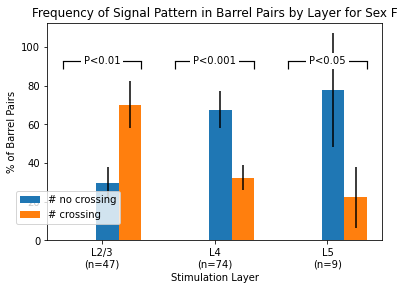

In [5]:
def significance_bar(start,end,height,displaystring,linewidth = 1.2,markersize = 8,boxpad  =0.3,fontsize = 15,color = 'k'):
    # draw a line with downticks at the ends
    plt.plot([start,end],[height]*2,'-',color = color,lw=linewidth,marker = TICKDOWN,markeredgewidth=linewidth,markersize = markersize)
    # draw the text with a bounding box covering up the line
    plt.text(0.5*(start+end),height,displaystring,ha = 'center',va='center',bbox=dict(facecolor='1.', edgecolor='none',boxstyle='Square,pad='+str(boxpad)),size = fontsize)

n_L23 = data['L2/3']['total']
n_L4 = data['L4']['total']
n_L5 = data['L5']['total']

plt.clf()
i = 0
tick_labels = []
colors = {"# no crossing": 'tab:blue', "# crossing": 'tab:orange'}
# in format # no crossing, # crossing, # no signal; l2/3, L4, L5

length_of_previous_sl = i

all_layers = []
totals = []
if n_L23 > 0:
    all_layers.append('L2/3')
    totals.append(n_L23)
if n_L4 > 0:
    all_layers.append('L4')
    totals.append(n_L4)
if n_L5 > 0:
    all_layers.append('L5')
    totals.append(n_L5)


# in columns L23, L4, L5
crossing_data = {
    "# no crossing": [data[x]['n_barrel_no_cross'] for x in all_layers],
    '# crossing': [data[x]['n_barrel_cross'] for x in all_layers],
    #'# no signal': [data[x]['n_barrel_none'] for x in ['L2/3', 'L4', 'L5']],
    #"L2/3": [3, 17, 30],
    #"L4": [38, 20, 30],
    #"L5": [8, 13, 1]
}
errbars = {}
for k in crossing_data:
    errbars[k] = [np.sqrt(x) for x in crossing_data[k]]
    for j in range(len(totals)):
        crossing_data[k][j] /= totals[j] / 100
        errbars[k][j] /= totals[j] / 100

labels = [x for x in crossing_data.keys()]
tick_labels += [all_layers[j] + "\n(n="+str(totals[j]) + ")"
                            for j in range(len(all_layers))]

print(errbars)
print(crossing_data)

# This is a binomial experiment of n independent trials.
# We use the Binomial case of goodness of fit test to a 
# chi-squared distribution
# (binomial test against p=0.5)
Zs = []
for i in range(3):
    layer = ['L2/3', 'L4', 'L5'][i]
    n = [n_L23, n_L4, n_L5][i]
    no_cr = crossing_data['# no crossing'][i]
    cr = crossing_data['# crossing'][i]
    k = n * cr / 100 # number of crosses
    
    null_hyp_p = 0.5
    
    Z = binom_test(k, n, null_hyp_p, alternative='greater')
    if Z > 0.5:
        Z = 1 - Z
    print("Binomial test for layer", layer, ":", Z)
    Zs.append(Z)
    
##########################
for nm in crossing_data:
    x = np.arange(len(all_layers))
    # else:
    plt.bar(x + (i-1.75) * 0.2, 
        crossing_data[nm],
        0.2,
        label=(nm if length_of_previous_sl == 0 else None),
        color=colors[nm])
    plt.errorbar(x + (i-1.75) * 0.2, 
                crossing_data[nm],
                yerr=errbars[nm],
                fmt='none',
                color='black')
    i += 1

for i in range(3):
    start = i - 0.35
    end = i + 0.35
    if Zs[i] < 0.001:
        significance_bar(start, end, 93, "P<0.001", fontsize=10)
    elif Zs[i] < 0.01:
        significance_bar(start, end, 93, "P<0.01", fontsize=10)
    elif Zs[i] < 0.05:
        significance_bar(start, end, 93, "P<0.05", fontsize=10)
    
plt.title("Frequency of Signal Pattern in Barrel Pairs by Layer for Sex " + sex)
plt.xlabel("Stimulation Layer")
plt.ylabel("% of Barrel Pairs")
#plt.xticks(rotation='vertical')
plt.xticks(np.arange(len(tick_labels)), tick_labels)
plt.legend(bbox_to_anchor=(0.062, 0.251), loc='upper center')
plt.savefig(data_dir + "results_count_oct2023_sex"+sex+".png")
plt.show()

In [6]:
# use Slice Edge and Medial Dir metadata
# to tell which barrel is more medial
# Mark this as Medial Crossing or Medial no crossing or lateral etc

In [7]:
# now separate by sex and try binomial test of crossing in L2/3
plt.clf()
i = 0
length_of_previous_sl = 0
tick_labels = []
colors = {"# no crossing": 'tab:blue', "# crossing": 'tab:orange'}
# in format # no crossing, # crossing, # no signal; l2/3, L4, L5
for sx in ['M', 'F']:
    
    length_of_previous_sl = i
    
    n_L23 = data['L2/3'][sx]['total']
    n_L4 = data['L4'][sx]['total']
    n_L5 = data['L5'][sx]['total']
    
    all_layers = []
    totals = []
    if n_L23 > 0:
        pass
        #all_layers.append('L2/3')
        #totals.append(n_L23)
    if n_L4 > 0:
        all_layers.append('L4')
        totals.append(n_L4)
    if n_L5 > 0:
        pass
        #all_layers.append('L5')
        #totals.append(n_L5)
    
    
    # in columns L23, L4, L5
    crossing_data = {
        "# no crossing": [data[x][sx]['n_barrel_no_cross'] for x in all_layers],
        '# crossing': [data[x][sx]['n_barrel_cross'] for x in all_layers],
        #'# no signal': [data[x][sl]['n_barrel_none'] for x in ['L2/3', 'L4', 'L5']],
        #"L2/3": [3, 17, 30],
        #"L4": [38, 20, 30],
        #"L5": [8, 13, 1]
    }
    errbars = {}
    for k in crossing_data:
        errbars[k] = [np.sqrt(x) for x in crossing_data[k]]
        for j in range(len(totals)):
            crossing_data[k][j] /= totals[j] / 100
            errbars[k][j] /= totals[j] / 100
            
    labels = [x for x in crossing_data.keys()]
    tick_labels += [all_layers[j] + "\n" + sx + "\n(n="+str(totals[j]) + ")"
                                for j in range(len(all_layers))]

    # plot this as bars 
    for nm in crossing_data:
        x = np.arange(length_of_previous_sl, len(all_layers) + length_of_previous_sl)
        '''        if i == length_of_previous_sl + 1:  # first iter of this sl
            plt.bar(x + (i-1) * 0.2, 
                    crossing_data[nm],
                    0.2,
                    label=nm,
                    tick_label=tick_labels)
                                #'L2/3\n(n='+str(n_L23)+')', 
                                #'L4\n(n='+str(n_L4)+')', 
                                #'L5\n(n='+str(n_L5)+')'])'''
        # else:
        plt.bar(x + (i-1) * 0.2, 
            crossing_data[nm],
            0.2,
            label=(nm if length_of_previous_sl == 0 else None),
            color=colors[nm])
        plt.errorbar(x + (i-1) * 0.2, 
                    crossing_data[nm],
                    yerr=errbars[nm],
                    fmt='none',
                    color='black')
        i += 1
    
plt.title("Frequency of Signal Pattern in Barrel Pairs by Sex")
plt.xlabel("Stimulation Layer")
plt.ylabel("% of Barrel Pairs")
plt.xticks(np.arange(len(tick_labels)), tick_labels)
#plt.xticks(rotation='vertical')
plt.legend(bbox_to_anchor=(0.55, .95), loc='upper center')
plt.savefig(data_dir + "results_count_prelim_" + str(datetime.date.today()) + ".png", bbox_inches="tight")
plt.show()

KeyError: 'M'

<Figure size 432x288 with 0 Axes>

In [ ]:
for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    dfd1 = df2['abs(delta 1)'].dropna()
    dfd2 = df2['abs(delta 2)'].dropna()

    print("Latency between barrel pairs in", stim_loc)
    dfds = np.concatenate([dfd1, dfd2])
    print("\t", 
          str(np.mean(dfds))[:5], 
          "+/-", 
          str(np.std(dfds))[:5], 
          "(n =", 
          str(len(dfds)) + ")")
    print("\t", dfds)

In [13]:
# L23
# Male: 
male_p_crossing = [20.030840419244385, 11.43663720812207, 27.95084971874737]
female_p_crossing = [12.22247371603836, 6.620242548062643, 15.713484026367725]
n_male = [18, 29, 8]
n_female = [47, 74, 9]

for i in range(3):
    n_m = n_male[i]
    n_f = n_female[i]
    p_m = male_p_crossing[i] / 100
    p_f = female_p_crossing[i] / 100
    p = (n_m * p_m + n_f * p_f) / (n_m + n_f)
    den = np.sqrt(p * (1-p) * (1/n_m + 1 / n_f))
    Z = (p_m - p_f) / den
    p_value = norm.sf(abs(Z)) * 2 # two-tailed test
    print(["L2/3", "L4", "L5"][i], ": Z=", Z, "p-value:", p_value)

L2/3 : Z= 0.802715168505981 p-value: 0.42213938361649084
L4 : Z= 0.8114604517450619 p-value: 0.4171012955085087
L5 : Z= 0.6133091060056557 p-value: 0.5396719734832298
